# Getting SalishSeaCast data for model-data comparison

In [1]:
import xarray
from salishsea_tools import geo_tools
import numpy as np
import gsw
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature
import cmocean as cm

In [164]:
# open the tracer dataset using a URL
files = ["/results2/SalishSea/nowcast-green.201905/13may22/SalishSea_1h_20220513_20220513_grid_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_grid_T.nc"]
dsT = xarray.open_dataset(files)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [101]:
lat = 50.116084
lon = -125.221528

i, j = geo_tools.get_ij_coordinates(lat,lon,grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

In [4]:
time_span = slice("2022-05-13 00:00:00", "2022-05-15 00:00:00")
temp = (
    dsT.temperature
    .sel(time=time_span)
    .sel(depth=2.1, method="nearest")
    .isel(gridY=j, gridX=i)
)

In [5]:
sal = (
    dsT.salinity
    .sel(time=time_span)
    .sel(depth=2.1, method="nearest")
    .isel(gridY=j, gridX=i)
)

In [135]:
# open the carbonate dataset using a URL
files = ["/results2/SalishSea/nowcast-green.201905/13may22/SalishSea_1h_20220513_20220513_carp_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_carp_T.nc"]
dsC = xarray.open_mfdataset(files)

In [7]:
dic = (
    dsC.dissolved_inorganic_carbon
    .sel(time_counter=time_span)
    .sel(deptht=2.1, method="nearest")
    .isel(y=j, x=i)
) 

In [8]:
alkalinity = (
    dsC.total_alkalinity
    .sel(time_counter=time_span)
    .sel(deptht=2.1, method="nearest")
    .isel(y=j, x=i)
) 

In [9]:
do = (
    dsC.dissolved_oxygen
    .sel(time_counter=time_span)
    .sel(deptht=2.1, method="nearest")
    .isel(y=j, x=i)
) 

In [10]:
# convert from conservative to in-situ temperature
P = np.zeros(len(temp))
P.fill(2)
t = gsw.conversions.t_from_CT(sal.values, temp.values, P)

In [11]:
d = {'time':do.time_counter.values, 'temperature (degC)':t, 'salinity ':sal.values,'dissolved oxygen (mmol m-3)':do.values,'DIC (mmol m-3)':dic.values,'alkalinity (mmol m-3)':alkalinity.values}
data = pd.DataFrame(d)

In [13]:
# data.to_csv('modelShaqData.csv')

## lets figure out wehere we should kayak

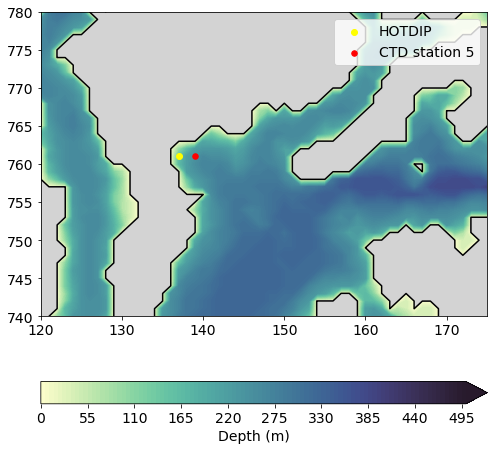

In [213]:
# Increase font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1,figsize=(8, 8))

# Load grid and mask files
# grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mesh = xarray.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

# Bathymetry
c = ax.contourf(
mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
cmap=cm.cm.deep, extend='max',zorder=0,
)
cbar = fig.colorbar(c, ax=ax, orientation='horizontal',label='Depth (m)')

# Make plot area
xlim, ylim = [120, 175], [740, 780]

# Overlay domain landmask and coastline
ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.scatter(i,j, c='yellow',label = 'HOTDIP')
ax.scatter(qu5['i'][0],qu5['j'][0],s=30,color = 'r',label='CTD station 5')
# ax.scatter(qu5['i'][0],qu5['j'][0],label='station 5')
# ax.scatter(qu39['i'][0],qu39['j'][0],label='station 39')
ax.legend()

## lets get surface DO and temp to copare to kayak transect

In [136]:
latmin, latmax = 50.115, 50.125
lonmin, lonmax = -125.23, -125.2
imax, jmax = geo_tools.get_ij_coordinates(latmax,lonmax,grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')
imin, jmin = geo_tools.get_ij_coordinates(latmin,lonmin,grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')

In [140]:
time_span = slice("2022-05-14 23:00:00", "2022-05-15 00:00:00")
temp = (
    dsT.temperature
    .sel(time=time_span)
    .sel(depth=0.3, method="nearest")
)

In [141]:
time_span = slice("2022-05-14 23:00:00", "2022-05-15 00:00:00")
do = (
    dsC.dissolved_oxygen
    .sel(time_counter=time_span)
    .sel(deptht=0.3, method="nearest")
)

In [16]:
# do.to_netcdf('modelsurfacedo.nc')

In [17]:
# temp.to_netcdf('modelsurfacetemp.nc')

In [ ]:
#import the kayak transect info
yak = pd.read_csv('kayak_cleaned.csv')

In [158]:
yak['i']= [geo_tools.get_ij_coordinates(yak['lat'][n],yak['lon'][n],grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')[0] for n in range(len(yak))]

In [159]:
yak['j']= [geo_tools.get_ij_coordinates(yak['lat'][n],yak['lon'][n],grid_loc='/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc')[1] for n in range(len(yak))]

In [165]:
yak.head()

,pos_time,lat,lon,TT_time,TT,DO_time,DO,i,j
0,'14-May-2022 15:36:23',50.117057,-125.226202,'14-May-2022 15:36:23',11.231,'14-May-2022 15:36:23',6.57,136,762
1,'14-May-2022 15:36:24',50.117065,-125.226153,'14-May-2022 15:36:24',11.243,'14-May-2022 15:36:24',6.65,136,762
2,'14-May-2022 15:36:25',50.117069,-125.226067,'14-May-2022 15:36:25',11.260,'14-May-2022 15:36:25',6.65,136,762
3,'14-May-2022 15:36:26',50.117089,-125.225970,'14-May-2022 15:36:26',11.278,'14-May-2022 15:36:26',6.65,136,762
4,'14-May-2022 15:36:27',50.117102,-125.225947,'14-May-2022 15:36:27',11.296,'14-May-2022 15:36:27',6.65,136,762


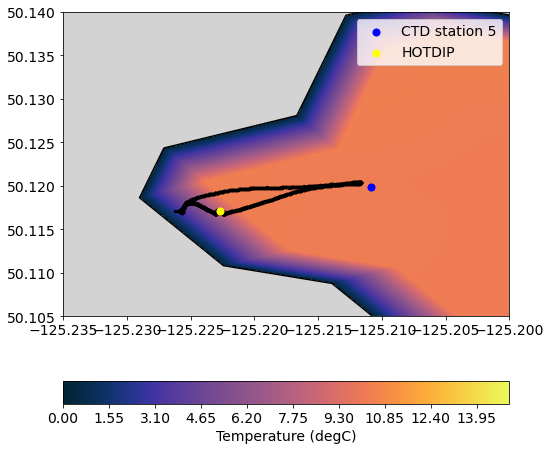

In [197]:
# Increase font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1,figsize=(8, 8))

# Load grid and mask files
# grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mesh = xarray.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

# Bathymetry
c = ax.contourf(
mesh.nav_lon, mesh.nav_lat,temp[0],levels=np.arange(0, 15.1, 0.05),
cmap=cm.cm.thermal,zorder=0,
)
cbar = fig.colorbar(c, ax=ax, orientation='horizontal',label='Temperature (degC)')


# Make plot area
xlim, ylim = [-125.235, -125.2], [50.105, 50.14]

# Overlay domain landmask and coastline
ax.contourf(mesh.nav_lon, mesh.nav_lat,mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
ax.contour(mesh.nav_lon, mesh.nav_lat,mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

ax.scatter(qu5['Longitude'][0],qu5['Latitude'][0],s=50,color = 'b',label='CTD station 5')
ax.scatter(yak['lon'],yak['lat'],s=5,c='k')
ax.scatter(-125.22266,50.11711, c='yellow',s=50,label = 'HOTDIP')
# ax.scatter(qu39['i'][0],qu39['j'][0],label='station 39')
ax.legend()
# ax.tight_layout()

In [191]:
# do factor
f = (1/(44.6596))*(1.42903)

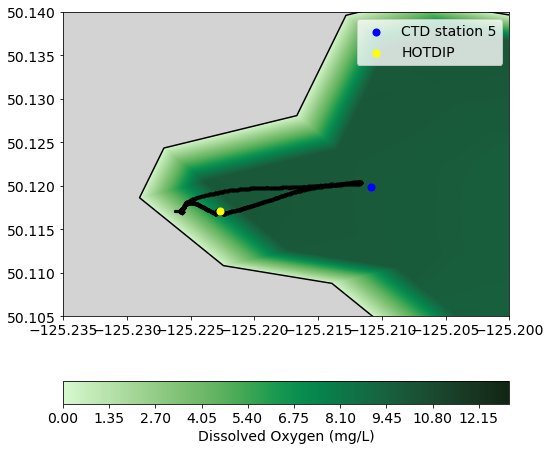

In [198]:
# Increase font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1,figsize=(8, 8))

# Load grid and mask files
# grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mesh = xarray.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

# Bathymetry
c = ax.contourf(
mesh.nav_lon, mesh.nav_lat,do[0]*f,levels=np.arange(0, 13.1, 0.05),
cmap=cm.cm.algae,zorder=0,
)
cbar = fig.colorbar(c, ax=ax, orientation='horizontal',label='Dissolved Oxygen (mg/L)')


# Make plot area
xlim, ylim = [-125.235, -125.2], [50.105, 50.14]

# Overlay domain landmask and coastline
ax.contourf(mesh.nav_lon, mesh.nav_lat,mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
ax.contour(mesh.nav_lon, mesh.nav_lat,mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

ax.scatter(qu5['Longitude'][0],qu5['Latitude'][0],s=50,color = 'b',label='CTD station 5')
ax.scatter(yak['lon'],yak['lat'],s=5,c='k')
ax.scatter(-125.22266,50.11711, c='yellow',s=50,label = 'HOTDIP')
# ax.scatter(qu39['i'][0],qu39['j'][0],label='station 39')
ax.legend()
# ax.tight_layout()

### Compare to CTD data

In [2]:
cols = ['Station','Latitude','Longitude','Measurement time','Depth (m)','Salinity (PSU)',
       'Temperature (deg C)','Fluorometry Chlorophyll (ug/L)','Dissolved O2 (mL/L)']

In [3]:
qu5 = pd.read_csv('8_binAvg_18812.csv',usecols=cols)
qu39 = pd.read_csv('8_binAvg_18813.csv',usecols=cols)
qu38 = pd.read_csv('8_binAvg_18850.csv',usecols=cols)
qu5x2 = pd.read_csv('8_binAvg_18851.csv',usecols=cols)
qu39x2 = pd.read_csv('8_binAvg_18852.csv',usecols=cols)
qu38x2 = pd.read_csv('1_datCnv_18850.csv',usecols=cols)

In [4]:
path = '/data/bmoorema/MEOPAR/grid/grid_from_lat_lon_mask999.nc'
qu5['i'], qu5['j'] = geo_tools.get_ij_coordinates(qu5['Latitude'][0],qu5['Longitude'][0],grid_loc=path)
qu5x2['i'], qu5x2['j'] = geo_tools.get_ij_coordinates(qu5x2['Latitude'][0],qu5x2['Longitude'][0],grid_loc=path)

In [119]:
qu5.head()

,Station,Latitude,Longitude,Measurement time,Depth (m),Temperature (deg C),Fluorometry Chlorophyll (ug/L),Dissolved O2 (mL/L),Salinity (PSU),i,j
0,QU5,50.119909,-125.210838,2022-05-03 12:17:29.291,0.991,10.8339,0.53257,8.0791,28.3469,139,761
1,QU5,50.119909,-125.210838,2022-05-03 12:17:30.876,1.983,10.7587,0.92999,8.0109,28.3940,139,761
2,QU5,50.119909,-125.210838,2022-05-03 12:17:32.152,2.974,10.6272,1.01390,8.0193,28.4300,139,761
3,QU5,50.119909,-125.210838,2022-05-03 12:17:33.361,3.966,10.4982,1.27750,8.0665,28.4582,139,761
4,QU5,50.119909,-125.210838,2022-05-03 12:17:34.537,4.957,10.4359,1.46300,8.0597,28.4804,139,761


In [120]:
# absolute salinity
qu5['abs_sal'] = gsw.SA_from_SP(qu5['Salinity (PSU)'], qu5['Depth (m)'], qu5['Longitude'], qu5['Latitude'])
qu5x2['abs_sal'] = gsw.SA_from_SP(qu5x2['Salinity (PSU)'], qu5x2['Depth (m)'], qu5x2['Longitude'], qu5x2['Latitude'])

In [59]:
# temperature in model
#39 and 5 were 3 and 10, 38 is 9 twice
files = ["/results2/SalishSea/nowcast-green.201905/03may22/SalishSea_1h_20220503_20220503_grid_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_grid_T.nc"]
dsT = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")

time_span = slice("2022-05-03 08:00:00", "2022-05-03 09:00:00")
temp5 = (
    dsT.temperature
    .sel(time=time_span)
    .isel(gridY=qu5['j'][0], gridX=qu5['i'][0])
)

files = ["/results2/SalishSea/nowcast-green.201905/10may22/SalishSea_1h_20220510_20220510_grid_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_grid_T.nc"]
dsT = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")

time_span = slice("2022-05-10 09:00:00", "2022-05-10 11:00:00")
temp5x2 = (
    dsT.temperature
    .sel(time=time_span)
    .isel(gridY=qu5['j'][0], gridX=qu5['i'][0])
)

In [61]:
#salinity

files = ["/results2/SalishSea/nowcast-green.201905/03may22/SalishSea_1h_20220503_20220503_grid_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_grid_T.nc"]
dsT = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")

time_span = slice("2022-05-03 08:00:00", "2022-05-03 09:00:00")
sal5 = (
    dsT.salinity
    .sel(time=time_span)
    .isel(gridY=qu5['j'][0], gridX=qu5['i'][0])

files = ["/results2/SalishSea/nowcast-green.201905/10may22/SalishSea_1h_20220510_20220510_grid_T.nc","/results2/SalishSea/nowcast-green.201905/14may22/SalishSea_1h_20220514_20220514_grid_T.nc"]
dsT = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")

time_span = slice("2022-05-10 09:00:00", "2022-05-10 11:00:00")
sal5x2 = (
    dsT.salinity
    .sel(time=time_span)
    .isel(gridY=qu5['j'][0], gridX=qu5['i'][0])
)

In [63]:
#DO
dsT = xarray.open_dataset("/results2/SalishSea/nowcast-green.201905/03may22/SalishSea_1h_20220503_20220503_carp_T.nc")

time_span = slice("2022-05-03 08:00:00", "2022-05-03 09:00:00")
do5 = (
    dsT.dissolved_oxygen
    .sel(time_counter=time_span)
    .isel(y=qu5['j'][0], x=qu5['i'][0])
)

dsT = xarray.open_dataset("/results2/SalishSea/nowcast-green.201905/10may22/SalishSea_1h_20220510_20220510_carp_T.nc")

time_span = slice("2022-05-10 09:00:00", "2022-05-10 11:00:00")
do5x2 = (
    dsT.dissolved_oxygen
    .sel(time_counter=time_span)
    .isel(y=qu5['j'][0], x=qu5['i'][0])
)

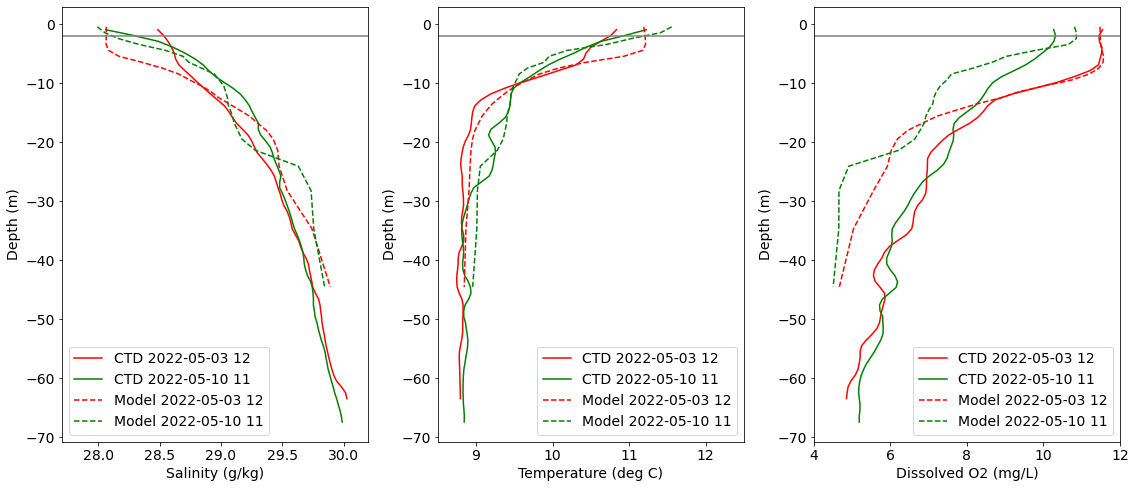

In [129]:
fig, ax = plt.subplots(1,3,figsize=(16,7))
plt.rcParams['font.size'] = 14

ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('Salinity (g/kg)')
ax[0].plot(qu5['abs_sal'],qu5[cols[4]]*-1,'r',label='CTD '+str(qu5[cols[3]][0][:13]))
ax[0].plot(qu5x2['abs_sal'],qu5x2[cols[4]]*-1,'g',label='CTD '+str(qu5x2[cols[3]][0][:13]))
ax[0].plot(sal5.values.T[:24],sal5.depth.values[:24]*-1,'r--',label='Model '+str(qu5[cols[3]][0][:13]))
ax[0].plot(sal5x2.values[0].T[:24],sal5x2.depth.values[:24]*-1,'g--',label='Model '+str(qu5x2[cols[3]][0][:13]))
ax[0].plot([0,100],[-2,-2],'grey')
ax[0].set_xlim([27.7,30.2])
ax[0].legend()

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlabel(cols[6])
ax[1].plot(qu5[cols[6]],qu5[cols[4]]*-1,'r',label='CTD '+str(qu5[cols[3]][0][:13]))
ax[1].plot(qu5x2[cols[6]],qu5x2[cols[4]]*-1,'green',label='CTD '+str(qu5x2[cols[3]][0][:13]))
ax[1].plot(temp5.values.T[:24],temp5.depth.values[:24]*-1,'r--',label='Model '+str(qu5[cols[3]][0][:13]))
ax[1].plot(temp5x2.values[0].T[:24],temp5x2.depth.values[:24]*-1,'g--',label='Model '+str(qu5x2[cols[3]][0][:13]))
ax[1].plot([0,100],[-2,-2],'grey')
ax[1].set_xlim([8.5,12.5])
ax[1].legend()

ax[2].set_ylabel('Depth (m)')
ax[2].set_xlabel("Dissolved O2 (mg/L)")
ax[2].plot(qu5[cols[8]]*(1.42903),qu5[cols[4]]*-1,'r',label='CTD '+str(qu5[cols[3]][0][:13]))
ax[2].plot(qu5x2[cols[8]]*(1.42903),qu5x2[cols[4]]*-1,'green',label='CTD '+str(qu5x2[cols[3]][0][:13]))
ax[2].plot(do5.values.T[:24]*f,do5.deptht.values[:24]*-1,'r--',label='Model '+str(qu5[cols[3]][0][:13]))
ax[2].plot(do5x2.values[0].T[:24]*f,do5x2.deptht.values[:24]*-1,'g--',label='Model '+str(qu5x2[cols[3]][0][:13]))
ax[2].plot([0,100],[-2,-2],'grey')
ax[2].set_xlim([4,12])
ax[2].legend()

plt.tight_layout()